In [174]:
import pandas as pd
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

if '..' not in sys.path:
    sys.path.append('..')

In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Value-at-Risk Student Prescription Tree
- Use seed=`121` for reproducibility.

In [206]:
from src.teachers.BinomGLM import BinomGLM
from src.DataGenerator import DataGenerator
from src.RiskAverseSPT import RiskAverseSPT 
from src.teachers.OptimalPrescription import OptimalPrescription

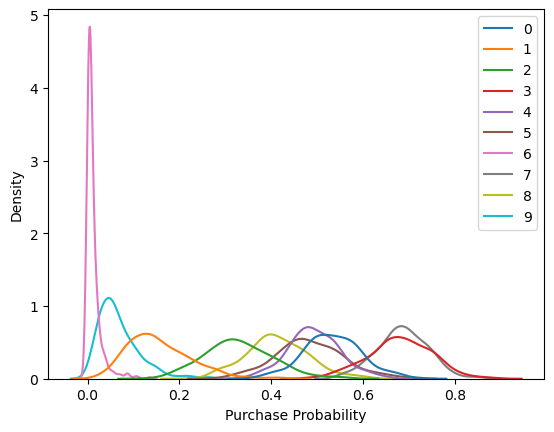

In [175]:
# init
gen = DataGenerator()
glm = BinomGLM()

dataset = 1
n_samples = 100

# load model
glm.load_params(
    f'../data/model=binomglm&dataset={dataset}&n_samples={n_samples}'
)

# get dataset
X, y, price, optimal_price = gen.generate_data(1, n_samples=100, seed=121)

# try inference
r = glm.predict_proba(price=5, X=X)

sns.kdeplot(r[:10, :].T)
plt.xlabel('Purchase Probability')
plt.show()

In [242]:
# get prices
prices = np.linspace(
    price.quantile(0.05),
    price.quantile(0.95),
    9
)

# split data into train and test
X_train, X_test, opt_price_train, opt_price_test = train_test_split(
    X, optimal_price, test_size=0.33, random_state=52)

# fit VaR-SPT
rat = RiskAverseSPT(
    teacher=glm, 
    prices=prices, 
    min_samples=10,
    risk_proba=0.05
)

# fit
rat.fit(X_train)

total_rev, avg_rev = rat.predict(X_test)

print('Total Revenue:', round(total_rev, 1))
print('Avg Revenue:', round(avg_rev, 3))

Total Revenue: 217.9
Avg Revenue: 6.604


In [247]:
total_rev, avg_rev = rat._get_true_revenue(X_test, opt_price_test)

print('Total Revenue:', round(total_rev, 1))
print('Avg Revenue:', round(avg_rev, 3))

Total Revenue: 154.3
Avg Revenue: 4.676


## Optimal Prescription Tree

Uses ground truth generative distribution to determine price threshold for purchases, use to build an optimal student prescription tree.

In [208]:
# init
opt = OptimalPrescription()

# fit
opt.fit(optimal_price)

# fit VaR-SPT
rat = RiskAverseSPT(
    teacher=opt, 
    prices=prices, 
    min_samples=10,
    risk_proba=0.05
)

# fit
rat.fit(X_train)

# predict
total_rev, avg_rev = rat.predict(X_test)

print('Total Revenue:', round(total_rev, 1))
print('Avg Revenue:', round(avg_rev, 2))

Total Revenue: 223.1
Avg Revenue: 6.76
